<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/feqFeacherTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [4]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'  # 예시 경로입니다. 실제 경로로 수정하세요.
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            if file_path.endswith('.csv'):
                data = pd.read_csv(file_path, header=None, skiprows=1).values  # 첫 번째 행을 제외하고 데이터 로드
                data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, 2)  # 여기서 2는 피처의 수입니다.
                data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
                X.append(data[:, 1])  # y 피처만 추출 (두 번째 열)
                y.append(category)
    X = [np.expand_dims(x, axis=-1) for x in X]  # y 피처만 있으므로 마지막 차원만 추가
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [5]:
# 샘플 데이터 출력
print("X_train shape:", X_train.shape)
print("y_train_categorical shape:", y_train_categorical.shape)
print("X_val shape:", X_val.shape)
print("y_val_categorical shape:", y_val_categorical.shape)
print("X_test shape:", X_test.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

# 데이터를 출력하기 위해 준비
sample_X_train = pd.DataFrame(X_train[0].reshape(-1, X_train.shape[1]))
sample_y_train_categorical = pd.DataFrame(y_train_categorical[:5])

# 첫 번째 샘플 데이터와 레이블 출력
print("\nX_train sample data:", sample_X_train)
print("\ny_train_categorical sample:", sample_y_train_categorical)

X_train shape: (7004, 12000, 1, 1)
y_train_categorical shape: (7004, 4)
X_val shape: (1278, 12000, 1, 1)
y_val_categorical shape: (1278, 4)
X_test shape: (1278, 12000, 1, 1)
y_test_categorical shape: (1278, 4)

X_train sample data:       0         1         2         3         4         5         6      \
0 -0.002856  0.002111  0.003312  0.006734  0.005235 -0.001269  0.003297   

      7        8        9      ...     11990    11991     11992     11993  \
0  0.009436  0.00441 -0.00298  ...  0.008833  0.01217  0.000704 -0.004197   

     11994     11995     11996   11997     11998     11999  
0 -0.00322  0.011968  0.000349 -0.0055  0.005712  0.007617  

[1 rows x 12000 columns]

y_train_categorical sample:      0    1    2    3
0  0.0  0.0  0.0  1.0
1  0.0  0.0  0.0  1.0
2  0.0  0.0  0.0  1.0
3  0.0  0.0  0.0  1.0
4  0.0  0.0  0.0  1.0


In [7]:
# CNN 모델 정의
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 1), activation='relu', input_shape=input_shape)) # reduce kernel size in dimension 1
    model.add(MaxPooling2D((2, 1))) # reduce pool size in dimension 1

    model.add(Conv2D(64, (3, 1), activation='relu')) # reduce kernel size in dimension 1
    model.add(MaxPooling2D((2, 1))) # reduce pool size in dimension 1

    model.add(Conv2D(128, (3, 1), activation='relu')) # reduce kernel size in dimension 1
    model.add(MaxPooling2D((2, 1))) # reduce pool size in dimension 1

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# 파라미터 설정
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # 입력 형식 조정
num_classes = len(categories)

# 모델 생성
model = create_cnn_model(input_shape, num_classes)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 모델 학습
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/10
219/219 [==============================] - 48s 220ms/step - loss: 0.4689 - accuracy: 0.8167 - val_loss: 0.1320 - val_accuracy: 0.9507
Epoch 2/10
219/219 [==============================] - 48s 221ms/step - loss: 0.0718 - accuracy: 0.9797 - val_loss: 0.0706 - val_accuracy: 0.9757
Epoch 3/10
219/219 [==============================] - 48s 217ms/step - loss: 0.1940 - accuracy: 0.9355 - val_loss: 0.0106 - val_accuracy: 0.9977
Epoch 4/10
219/219 [==============================] - 48s 220ms/step - loss: 0.1018 - accuracy: 0.9683 - val_loss: 0.0643 - val_accuracy: 0.9804
Epoch 5/10
219/219 [==============================] - 47s 216ms/step - loss: 0.0718 - accuracy: 0.9720 - val_loss: 0.0034 - val_accuracy: 0.9984
Epoch 6/10
219/219 [==============================] - 48s 219ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/10
219/219 [==============================] - 48s 219ms/step - loss: 0.1960 - accuracy: 0.9316 - val_loss: 0.1269 - val_ac

In [10]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy*100:.2f}%')

40/40 [==============================] - 2s 40ms/step - loss: 0.0218 - accuracy: 0.9914
테스트 손실: 0.0218
테스트 정확도: 99.14%


In [11]:
# 모델 저장
model.save('ship_fault_classification_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


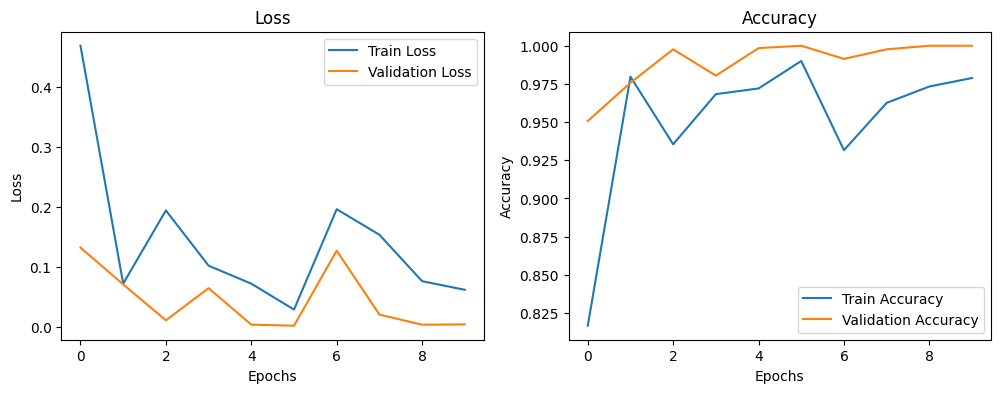

In [17]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

40/40 [==============================] - 2s 45ms/step


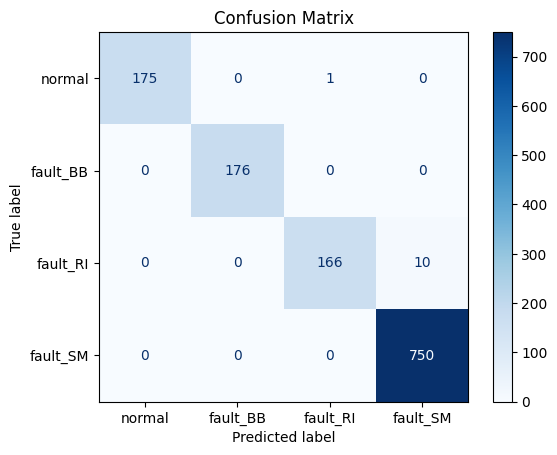

In [20]:
# 혼동 행렬 출력
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()